# Using TensorRT to Optimize Caffe Models in Python

TensorRT 4.0 includes support for a Python API to load in and optimize Caffe models, which can then be executed and stored.

First, we import TensorRT.

In [1]:
import tensorrt as trt

We use PyCUDA to transfer data to/from the GPU and NumPy to store data.

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np

For this example, we also want to import `pillow` (an image processing library) and `randint`.

In [3]:
from random import randint
from PIL import Image
from matplotlib.pyplot import imshow #to show test case

Since we are converting a Caffe model, we also need to use the `caffeparser` located in `tensorrt.parsers`.

In [4]:
from tensorrt import parsers

Typically, the first thing you will do is create a logger, which is used extensively during the model conversion and inference process. We provide a simple logger implementation in `tensorrt.infer.ConsoleLogger`, but you can define your own as well.

In [5]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)

Now, we define some constants for our model, which we will use to classify digits from the MNIST dataset.

In [6]:
INPUT_LAYERS = ['data']
OUTPUT_LAYERS = ['prob']
INPUT_H = 28
INPUT_W =  28
OUTPUT_SIZE = 10

We now define data paths. Please change these to reflect where you placed the data included with the samples.

In [7]:
MODEL_PROTOTXT = './data/mnist/mnist.prototxt'
CAFFE_MODEL = './data/mnist/mnist.caffemodel'
DATA = './data/mnist/'
IMAGE_MEAN = './data/mnist/mnist_mean.binaryproto'

The first step is to create our engine. The Python API provides utilities to make this simpler. Here, we use the caffe model converter utility in `tensorrt.utils`. We provide a logger, a path to the model prototxt, the model file, the max batch size, the max workspace size, the output layer(s) and the data type of the weights.

In [8]:
engine = trt.utils.caffe_to_trt_engine(G_LOGGER,
                                       MODEL_PROTOTXT,
                                       CAFFE_MODEL,
                                       1, 
                                       1 << 20, 
                                       OUTPUT_LAYERS,
                                       trt.infer.DataType.FLOAT)

Building Engine


Now let's generate a test case for our engine.

Test Case: 4


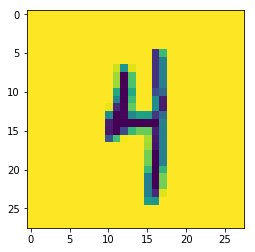

In [9]:
rand_file = randint(0,9)
path = DATA + str(rand_file) + '.pgm'
im = Image.open(path)
%matplotlib inline
imshow(np.asarray(im))
arr = np.array(im)
img = arr.ravel()
print("Test Case: " + str(rand_file))

We now need to apply the mean to the input image; we have this stored in a .binaryproto file which can be read by the caffeparser.

In [10]:
parser = parsers.caffeparser.create_caffe_parser()
mean_blob = parser.parse_binary_proto(IMAGE_MEAN)
parser.destroy()
#NOTE: This is different than the C++ API, you must provide the size of the data
mean = mean_blob.get_data(INPUT_W ** 2) 
data = np.empty([INPUT_W ** 2])
for i in range(INPUT_W ** 2):
    data[i] = float(img[i]) - mean[i]
mean_blob.destroy()    

Now we need to create a runtime for inference and create a context for our engine.

In [11]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()

Now we can run inference. We first make sure our data is in the correct datatype (FP32 for this model). Then, we allocate an empty array on the CPU to store our results from inference.

In [12]:
assert(engine.get_nb_bindings() == 2)
#convert input data to Float32
img = img.astype(np.float32)
#create output array to receive data 
output = np.empty(OUTPUT_SIZE, dtype = np.float32)

Now, we allocate memory on the GPU with PyCUDA and register it with the engine. The size of the allocations is the size of the input/expected output * the batch size.

In [13]:
d_input = cuda.mem_alloc(1 * img.size * img.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

The engine needs bindings provided as pointers to the GPU memory. PyCUDA lets us do this for memory allocations by casting those allocations to ints.

In [14]:
bindings = [int(d_input), int(d_output)]

We then create a cuda stream to run inference.

In [15]:
stream = cuda.Stream()

Now we transfer the data to the GPU, run inference and the copy the results back.

In [16]:
#transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
#execute model 
context.enqueue(1, bindings, stream.handle, None)
#transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
#syncronize threads
stream.synchronize()

We can run `np.argmax` to get a prediction.

In [17]:
print("Test Case: " + str(rand_file))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 4
Prediction: 4


We can also write our engine to a file to use later.

In [18]:
trt.utils.write_engine_to_file("./data/mnist/new_mnist.engine", engine.serialize())

True

You can load this engine later by using `tensorrt.utils.load_engine`.

In [19]:
new_engine = trt.utils.load_engine(G_LOGGER, "./data/mnist/new_mnist.engine")

Finally, we clean up our context, engine and runtime

In [20]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()